In [120]:
import requests,os,time
def ratelimit():
    "A function that handles the rate of your calls."
    time.sleep(0.5) # sleep one second.

class Connector():
  def __init__(self,logfile,overwrite_log=False,connector_type='requests',session=False,path2selenium='',n_tries = 5,timeout=30):
    """This Class implements a method for reliable connection to the internet and monitoring. 
    It handles simple errors due to connection problems, and logs a range of information for basic quality assessments
    
    Keyword arguments:
    logfile -- path to the logfile
    overwrite_log -- bool, defining if logfile should be cleared (rarely the case). 
    connector_type -- use the 'requests' module or the 'selenium'. Will have different since the selenium webdriver does not have a similar response object when using the get method, and monitoring the behavior cannot be automated in the same way.
    session -- requests.session object. For defining custom headers and proxies.
    path2selenium -- str, sets the path to the geckodriver needed when using selenium.
    n_tries -- int, defines the number of retries the *get* method will try to avoid random connection errors.
    timeout -- int, seconds the get request will wait for the server to respond, again to avoid connection errors.
    """
    
    ## Initialization function defining parameters. 
    self.n_tries = n_tries # For avoiding triviel error e.g. connection errors, this defines how many times it will retry.
    self.timeout = timeout # Defining the maximum time to wait for a server to response.
    ## not implemented here, if you use selenium.
    if connector_type=='selenium':
      assert path2selenium!='', "You need to specify the path to you geckodriver if you want to use Selenium"
      from selenium import webdriver 
      ## HIN download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases

      assert os.path.isfile(path2selenium),'You need to insert a valid path2selenium the path to your geckodriver. You can download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases'
      self.browser = webdriver.Firefox(executable_path=path2selenium) # start the browser with a path to the geckodriver.

    self.connector_type = connector_type # set the connector_type
    
    if session: # set the custom session
      self.session = session
    else:
      self.session = requests.session()
    self.logfilename = logfile # set the logfile path
    ## define header for the logfile
    header = ['id','project','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
    if os.path.isfile(logfile):        
      if overwrite_log==True:
        self.log = open(logfile,'w')
        self.log.write(';'.join(header))
      else:
        self.log = open(logfile,'a')
    else:
      self.log = open(logfile,'w')
      self.log.write(';'.join(header))
    ## load log 
    with open(logfile,'r') as f: # open file
        
      l = f.read().split('\n') # read and split file by newlines.
      ## set id
      if len(l)<=1:
        self.id = 0
      else:
        self.id = int(l[-1][0])+1
            
  def get(self,url,project_name):
    """Method for connector reliably to the internet, with multiple tries and simple error handling, as well as default logging function.
    Input url and the project name for the log (i.e. is it part of mapping the domain, or is it the part of the final stage in the data collection).
    
    Keyword arguments:
    url -- str, url
    project_name -- str, Name used for analyzing the log. Use case could be the 'Mapping of domain','Meta_data_collection','main data collection'. 
    """
     
    project_name = project_name.replace(';','-') # make sure the default csv seperator is not in the project_name.
    if self.connector_type=='requests': # Determine connector method.
      for _ in range(self.n_tries): # for loop defining number of retries with the requests method.
        ratelimit()
        t = time.time()
        try: # error handling 
          response = self.session.get(url,timeout = self.timeout) # make get call

          err = '' # define python error variable as empty assumming success.
          success = True # define success variable
          redirect_url = response.url # log current url, after potential redirects 
          dt = t - time.time() # define delta-time waiting for the server and downloading content.
          size = len(response.text) # define variable for size of html content of the response.
          response_code = response.status_code # log status code.
          ## log...
          call_id = self.id # get current unique identifier for the call
          self.id+=1 # increment call id
          #['id','project_name','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row to be written in the log.
          self.log.write('\n'+';'.join(map(str,row))) # write log.
          self.log.flush()
          return response,call_id # return response and unique identifier.

        except Exception as e: # define error condition
          err = str(e) # python error
          response_code = '' # blank response code 
          success = False # call success = False
          size = 0 # content is empty.
          redirect_url = '' # redirect url empty 
          dt = t - time.time() # define delta t

          ## log...
          call_id = self.id # define unique identifier
          self.id+=1 # increment call_id

          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row
          self.log.write('\n'+';'.join(map(str,row))) # write row to log.
          self.log.flush()
    else:
      t = time.time()
      ratelimit()
      self.browser.get(url) # use selenium get method
      ## log
      call_id = self.id # define unique identifier for the call. 
      self.id+=1 # increment the call_id
      err = '' # blank error message
      success = '' # success blank
      redirect_url = self.browser.current_url # redirect url.
      dt = t - time.time() # get time for get method ... NOTE: not necessarily the complete load time.
      size = len(self.browser.page_source) # get size of content ... NOTE: not necessarily correct, since selenium works in the background, and could still be loading.
      response_code = '' # empty response code.
      row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row 
      self.log.write('\n'+';'.join(map(str,row))) # write row to log file.
      self.log.flush()
    # Using selenium it will not return a response object, instead you should call the browser object of the connector.
    ## connector.browser.page_source will give you the html.
      return None,call_id

In [121]:
connector = Connector('Exam day 3')
from bs4 import BeautifulSoup
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import requests
import nltk, nltk.sentiment, sklearn
%matplotlib inline
name=nltk.corpus.names

In [134]:
path2data='C:/Users/frede/OneDrive/Documents/GitHub/Group/Group-31-SoDa/Data/movie.csv'
done=pd.read_csv(path2data)

# DATA CLEANING
# STARS
done['Top Star']=done['Top Star'].str.replace(',','')
done['Star 2']=done['Star 2'].str.replace(',','')
done['Star 3']=done['Star 3'].str.replace(',','')
# GROSS
done["Gross"] = done["Gross"].str.replace("M","")
done["Gross"] = done["Gross"].str.replace("$","")
done["Gross"] = done['Gross'].convert_objects(convert_numeric=True)
# GENRE
done["Genre"] = pd.Series(done["Genre"])
new1 = done["Genre"].str.split(",", expand=True)
done["Genre 1"]= new1[0] 
done["Genre 2"]= new1[1]
done["Genre 3"]= new1[2]
done=done.drop(['Unnamed: 0','Genre'],axis=1)
done.head()
# DIRECTORS
new1 = done["Director"].str.split(" ", expand=True)
done["D_first"]= new1[0] 
done["F_last"]= new1[1]
done.head(10)

C:\Users\frede\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if sys.path[0] == '':


,Title,Year,Rating,Gross,Director,Summary,Top Star,Star 2,Star 3,Star 4,Genre 1,Genre 2,Genre 3,D_first,F_last
0,En verden udenfor,1994,9.3,28.34,Frank Darabont,Two imprisoned men bond over a number of years...,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,Drama,None,None,Frank,Darabont
1,The Dark Knight,2008,9.0,534.86,Christopher Nolan,When the menace known as The Joker emerges fro...,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,Action,Crime,Drama,Christopher,Nolan
2,Inception,2010,8.8,292.58,Christopher Nolan,A thief who steals corporate secrets through t...,Leonardo DiCaprio,Joseph Gordon-Levitt,Ellen Page,Ken Watanabe,Action,Adventure,Sci-Fi,Christopher,Nolan
3,Fight Club,1999,8.8,37.03,David Fincher,An insomniac office worker and a devil-may-car...,Brad Pitt,Edward Norton,Meat Loaf,Zach Grenier,Drama,None,None,David,Fincher
4,Pulp Fiction,1994,8.9,107.93,Quentin Tarantino,"The lives of two mob hitmen, a boxer, a gangst...",John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis,Crime,Drama,None,Quentin,Tarantino
5,Forrest Gump,1994,8.8,330.25,Robert Zemeckis,"The presidencies of Kennedy and Johnson, the e...",Tom Hanks,Robin Wright,Gary Sinise,Sally Field,Drama,Romance,None,Robert,Zemeckis
6,The Matrix,1999,8.7,171.48,"['Lana Wachowski, ', 'Lilly Wachowski']",A computer hacker learns from mysterious rebel...,Keanu Reeves,Laurence Fishburne,Carrie-Anne Moss,Hugo Weaving,Action,Sci-Fi,None,['Lana,"Wachowski,"
7,Ringenes herre: Eventyret om ringen,2001,8.8,315.54,Peter Jackson,A meek Hobbit from the Shire and eight compani...,Elijah Wood,Ian McKellen,Orlando Bloom,Sean Bean,Adventure,Drama,Fantasy,Peter,Jackson
8,Ringenes herre: Kongen vender tilbage,2003,8.9,377.85,Peter Jackson,Gandalf and Aragorn lead the World of Men agai...,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,Adventure,Drama,Fantasy,Peter,Jackson
9,The Dark Knight Rises,2012,8.4,448.14,Christopher Nolan,Eight years after the Joker's reign of anarchy...,Christian Bale,Tom Hardy,Anne Hathaway,Gary Oldman,Action,Thriller,None,Christopher,Nolan


In [66]:
# SCRABE FEMALE FIRST NAMES AND OTHERS
first_female=[]
sur_female=[]
full_f=[]
for i in range(1,8):
    url='https://imdb.com/list/ls022928836/?sort=list_order,asc&mode=detail&page={}'.format(i)
    call='Exam, KU, Female Page {}'.format(i)
    response,call_id = connector.get(url, call)
    html = response.text
    soup=str(html)
    if i < 7:
        for i in range(1,101):
            first_female.append((soup.split('div class="lister-list"')[1].split('h3 class')[i].split('</span>\n<a href=')[1].split('>')[1].split('\n')[0].split(' ')[1]))
            sur_female.append((soup.split('div class="lister-list"')[1].split('h3 class')[i].split('</span>\n<a href=')[1].split('>')[1].split('\n')[0].split(' ')[2:]))
            full_f.append((soup.split('div class="lister-list"')[1].split('h3 class')[i].split('</span>\n<a href=')[1].split('>')[1].split('\n')[0].lstrip()))
    if i == 7:
        for i in range(1,7):
            first_female.append((soup.split('div class="lister-list"')[1].split('h3 class')[i].split('</span>\n<a href=')[1].split('>')[1].split('\n')[0].split(' ')[1]))
            sur_female.append((soup.split('div class="lister-list"')[1].split('h3 class')[i].split('</span>\n<a href=')[1].split('>')[1].split('\n')[0].split(' ')[2:]))
            full_f.append((soup.split('div class="lister-list"')[1].split('h3 class')[i].split('</span>\n<a href=')[1].split('>')[1].split('\n')[0].lstrip()))
# SCRABE MALE FIRST NAMES AND OTHERS
first_male=[]
sur_male=[]
full_m=[]
for i in range (1,8):
    url='https://www.imdb.com/list/ls022928819/?sort=list_order,asc&mode=detail&page={}'.format(i)
    call='Exam, KU, Male Page {}'.format(i)
    response,call_id = connector.get(url, call)
    html = response.text
    soup=str(html)
    if i < 7:
        for i in range(1,101):
            first_male.append((soup.split('div class="lister-list"')[1].split('h3 class')[i].split('</span>\n<a href=')[1].split('>')[1].split('\n')[0].split(' ')[1]))
            sur_male.append((soup.split('div class="lister-list"')[1].split('h3 class')[i].split('</span>\n<a href=')[1].split('>')[1].split('\n')[0].split(' ')[2:]))
            full_m.append((soup.split('div class="lister-list"')[1].split('h3 class')[i].split('</span>\n<a href=')[1].split('>')[1].split('\n')[0].lstrip()))
    if i == 7:
        for i in range(1,82):
            first_male.append((soup.split('div class="lister-list"')[1].split('h3 class')[i].split('</span>\n<a href=')[1].split('>')[1].split('\n')[0].split(' ')[1]))
            sur_male.append((soup.split('div class="lister-list"')[1].split('h3 class')[i].split('</span>\n<a href=')[1].split('>')[1].split('\n')[0].split(' ')[2:]))
            full_m.append((soup.split('div class="lister-list"')[1].split('h3 class')[i].split('</span>\n<a href=')[1].split('>')[1].split('\n')[0].lstrip()))

first_m=list(dict.fromkeys(first_male))
first_f=list(dict.fromkeys(first_female))

# REMOVING DUPLICATES BY MAKING INTO DICT AND BACK AGAIN

male_name=name.words('male.txt')+first_m
first_m_done=list(dict.fromkeys(male_name))

female_name=name.words('female.txt')+first_f
first_f_done=list(dict.fromkeys(female_name))

In [185]:
oc_new=[ x for x in name.words('male.txt') if x in name.words('female.txt')]

In [188]:
oc_new=shape()

NameError: name 'shape' is not defined

In [135]:
rev=str(done['Top Star'])
tokenizer = nltk.tokenize.TweetTokenizer()

def preprocessing(string):
    token=tokenizer.tokenize(string)
    return token
def count_dictionary(dic,doc):
    doc_new=[ x for x in doc if x in dic]
    return len(doc_new)

done['m_count']=done['Top Star'].apply(preprocessing).apply(count_dictionary, doc=first_m_done)
done['f_count']=done['Top Star'].apply(preprocessing).apply(count_dictionary, doc=first_f_done)
done['star_m']=done['Top Star'].apply(count_dictionary, doc=full_m)
done['star_f']=done['Top Star'].apply(count_dictionary, doc=full_f)
done['d_m_count']=done['Director'].apply(preprocessing).apply(count_dictionary, doc=first_m_done)
done['d_f_count']=done['Director'].apply(preprocessing).apply(count_dictionary, doc=first_f_done)

In [137]:
# Gender-matching, actor
done.loc[(done.m_count > 0), 'Male'] = 1
done.loc[(done.f_count > 0), 'Female'] = 1
done.loc[(done.f_count > 0) & (done.m_count > 0), 'Neutral'] = 1
done.loc[(done.star_m) ==1, 'Neutral'] = 0
done.loc[(done.star_m) ==1, 'Female'] = 0
done.loc[(done.star_f) ==1, 'Neutral'] = 0
done.loc[(done.star_f) ==1, 'Male'] = 0
done.loc[(done.m_count==0) & (done.f_count==0) & (done.star_m==0) & (done.star_f==0), 'Non'] = 1
done.loc[done.Neutral==1, 'Male'] = 0
done.loc[done.Neutral==1, 'Female'] = 0


# Gender-matching, director
done.loc[(done.d_m_count > 0), 'd_Male'] = 1
done.loc[(done.d_f_count > 0), 'd_Female'] = 1
done.loc[(done.d_f_count > 0) & (done.d_m_count > 0), 'd_Neutral'] = 1
done.loc[done.d_Neutral==1, 'd_Male'] = 0
done.loc[done.d_Neutral==1, 'd_Female'] = 0
done.sum(axis=0, skipna=True)


Title        En verden udenforThe Dark KnightInceptionFight...
Year                                                  20047040
Rating                                                 64896.3
Gross                                                   269830
Director     Frank DarabontChristopher NolanChristopher Nol...
Summary      Two imprisoned men bond over a number of years...
Top Star     Tim Robbins Christian Bale Leonardo DiCaprio B...
Genre 1      DramaActionActionDramaCrimeDramaActionAdventur...
D_first      FrankChristopherChristopherDavidQuentinRobert[...
m_count                                                   8783
f_count                                                   4004
star_m                                                    3582
star_f                                                    1335
d_m_count                                                10088
d_f_count                                                 2458
Male                                                   

# Plots

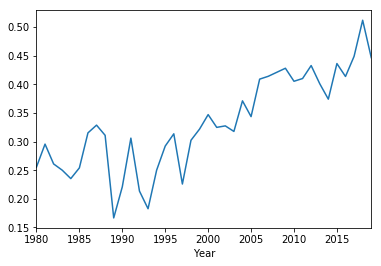

In [180]:
plot=done[done.Neutral != 1]
plot_1=plot[plot.Non !=1]
plot_1.drop(columns=['Top Star','Star 2','Star 3','Star 4','star_f','star_m','m_count','f_count','d_m_count','d_f_count','Non'])
yr_plt=plot_1.groupby('Year')
yr_plt['Female'].mean().plot()
yr_dir=plot_1.groupby(['Year','d_Male'])

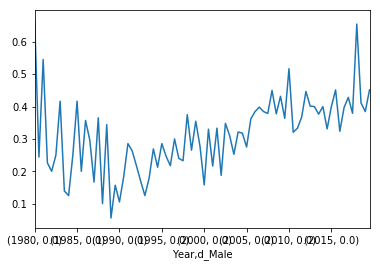

In [183]:
yr_dir['Female'].mean().plot(x='Year')